In [141]:
import networkx as nx
import numpy as np
import pickle 
import pandas as pd

fr = open('MatrixD.pkl','rb')  
dat = pickle.load(fr)

In [142]:
df = dat[1995]
len(df[0]), len(df)

(102, 242)

# MATRIX TO EDGELIST

In [143]:
dat = []
for i in range(len(df)):
    for j in range(len(df[i])):
        #if df[i][j]:
        dat.append(['row'+str(i), 'col' + str(j), df[i][j]])

len(dat)

24684

In [144]:
G = nx.DiGraph()
for i in dat:
    G.add_edge( i[1], i[0], weight = i[2])

nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 344\nNumber of edges: 24684\nAverage in degree:  71.7558\nAverage out degree:  71.7558'

# hits

In [145]:
h, a = nx.hits(G)

In [146]:

country_ids = [i for i in list(G.nodes) if 'col' in i]
df1 = [(i, h[i]) for i in country_ids]
df1 = pd.DataFrame(df1, columns = ['id', 'hub'])
df1['ids'] = [int(i.split('col')[1]) for i in df1['id'].tolist()]
df1 = df1.sort_values(by = 'ids', ascending = True)
len(df1['hub'])

102

In [147]:
country_ids = [i for i in list(G.nodes) if 'row' in i]
df2 = [(i, a[i]) for i in country_ids]
df2 = pd.DataFrame(df2, columns = ['id', 'aut'])
df2['ids'] = [int(i.split('row')[1]) for i in df2['id'].tolist()]
df2 = df2.sort_values(by = 'ids', ascending = True)
len(df2['aut'])

242

# ECI & PCI

https://nbviewer.jupyter.org/github/hashc/Skills/blob/master/ecomplexity.ipynb

In [90]:
def RCA(Xcp):
    """
    Xcp is a numpy.matrix type
    --|steel|oil|chip|bean|clothes
    --|--|--|--|--|--
    USA|1|1|1|1|0
    China|1|0|0|1|1
    Viet Nam|0|0|0|1|1
    """
    if type(Xcp) is not np.matrix:
        if type(Xcp) is np.array or list:
            Xcp = np.matrix(Xcp)
        else:
            raise ValueError('Xcp must be matrix')
    else:
        pass
    B = Xcp.sum(1)*Xcp.sum(0) 
    Sum = Xcp.sum()
    return Xcp*Sum/B
    
def fliterRCA(R):
    M = R>1
    return M.astype(float)


def Get_eci_pci(M):
    d = M.sum(1).T.tolist()[0]
    u = M.sum(0).tolist()[0]
    D = np.diag([1.0/i if i>0 else 0. for i in d])
    U = np.diag([1.0/i if i>0 else 0. for i in u])
    mcp1 = D * M
    mcp2 = M * U
    
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    eigvals, eigvecs = np.linalg.eig(Mpp)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 @ kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp  
    return eci.T.tolist()[0],pci.T.tolist()[0]

def Get_eci_pci_sparse(M):
    d = M.sum(1).T.tolist()[0]
    u = M.sum(0).tolist()[0]
    nd,nu = len(d),len(u)
    D1 = scipy.sparse.csc_matrix(([1.0/i if i>0 else 0. for i in d], (range(nd), range(nd))),shape=(nd,nd))
    U1 = scipy.sparse.csc_matrix(([1.0/i if i>0 else 0. for i in u], (range(nu), range(nu))),shape=(nu,nu))
    M = sparse.csc_matrix(M)
    mcp1 = D1 * M
    mcp2 = M * U1
    Mcc = mcp1 @ mcp2.T
    Mpp = mcp2.T @ mcp1
    A=scipy.sparse.csc_matrix(Mpp)
    eigvals, eigvecs = scipy.sparse.linalg.eigs(A, k=2)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 @ kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp
    return eci,pci

def Get_z_score(x):
    x=np.array(x)
    std=np.std(x)
    mean=np.mean(x)
    return (x-mean)/std

In [92]:
c = dat[1995] # MatrixD[1995]
R = RCA(c)
M = fliterRCA(R)
eci,pci = Get_eci_pci(np.matrix(M))

/Users/datalab/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/datalab/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater


In [127]:
len(eci), len(pci), len(hub)

(242, 102, 102)

In [148]:
pci_z = Get_z_score(pci)
eci_z = Get_z_score(eci)

hub = df1['hub'].tolist()
aut = df2['aut'].tolist()

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

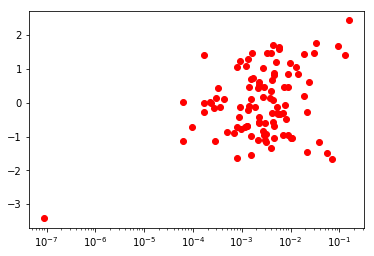

In [138]:
plt.plot(hub, pci_z, 'ro')
plt.xscale('log');
#plt.yscale('log');

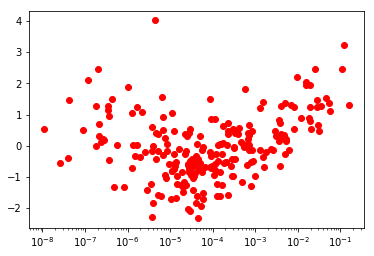

In [149]:
plt.plot(aut, eci_z, 'ro')
plt.xscale('log');
#plt.yscale('log');

# iteration methods of eci

https://github.com/hashc/Skills/blob/master/iter_eci.py

In [154]:
import numpy as  np
import copy 
c=np.array([[1.,1.,1.,1.],[0.,1.,0.,0.],[0.,0.,1.,1.],[0.,0.,0.,1.]])
def eci(c):
	c.astype(np.float64)
	a=c.sum(1)
	b = c.sum(0)
	a0 = copy.deepcopy(a)
	b0 = copy.deepcopy(b)
	for _ in range(100):
		a1 = copy.deepcopy(a)
		for i in range(len(a)):
			a1[i] = 1.0*sum([b[j] for j in range(len(a)) if c[i,j]])/a0[i]
		b1 = copy.deepcopy(b)
		for j in range(len(b)):
			b1[j] =  1.0*sum([a[i] for i in range(len(b)) if c[i,j]])/b0[j]
		#print(a1,b1)
		a=a1
		b=b1
	return a,b

eci(c)

(array([2.75, 2.75, 2.75, 2.75]), array([2.25, 2.25, 2.25, 2.25]))

# END

In [122]:
import pickle 

fr = open('cdata_res.pkl','rb')  
dat = pickle.load(fr)

In [123]:
dat.keys()

dict_keys(['ECI', 'density', 'cog', 'PCI'])

In [124]:
dat['ECI']['~019343c06c6a15aa47']

0.11142756821655171